In [50]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from datetime import datetime, timedelta
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn import tree
from sklearn.metrics import confusion_matrix, log_loss, f1_score, accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from xgboost import XGBClassifier

In [69]:
#read through this: https://www.kaggle.com/the1owl/regressing-during-insomnia-0-21496

## Getting the data

In [6]:
path= "../../Downloads/Predict_churn/"

In [7]:
trainset = pd.read_csv(path+"train_v2.csv")

In [8]:
members = pd.read_csv(path+"members_v2.csv")

In [9]:
samplesubmission = pd.read_csv(path+"sample_submission_v2.csv")

In [10]:
transactions = pd.read_csv(path+'transactions_v2.csv',parse_dates=['transaction_date','membership_expire_date']).reset_index(drop=True)
#transactions = transactions.sort_values(by=['transaction_date'], ascending=[False]).reset_index(drop=True)

In [61]:
# Only leave the last transaction as a predictor - this should be done after the number of transactions has been recorded. 
transactions = transactions.sort_values(by=['transaction_date'], ascending=[False]).reset_index(drop=True)
transactions = transactions.drop_duplicates(subset=['msno'], keep='first')

## Basic info

In [ ]:
members.describe()

In [ ]:
members.info()

In [ ]:
members["registered_via"].value_counts()

In [260]:
#How many msno-s are included in the testset but not included in the transactions dataset?
print (list(set(samplesubmission["msno"])-set(transactions["msno"])))

#How many msno-s are included in the testset dataset but not included in the members dataset?
print (list(set(samplesubmission["msno"])-set(transactions["msno"])))


['VJx7ZXB+BP/true7UpJTYyAsv7ItjWWaRrtY/Zg0+VE=']
['VJx7ZXB+BP/true7UpJTYyAsv7ItjWWaRrtY/Zg0+VE=']


In [ ]:
#How many msno-s are in the transactions dataset but not in the members dataset?
print len(list(set(transactions["msno"])-set(members["msno"])))

#How many are in the members dataset but not in transactions?
print len(list(set(members["msno"])-set(transactions["msno"])))

# Transactions dataset contains data about a lot more users than the members dataset. 

# Cleaning features

In [12]:
# Nan values
members['city'] = members.city.apply(lambda x: int(x) if pd.notnull(x) else "NAN")
members['registered_via'] = members.registered_via.apply(lambda x: int(x) if pd.notnull(x) else "NAN")
members['gender']=members['gender'].fillna("NAN")
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 795090 entries, 0 to 795089
Data columns (total 6 columns):
msno                      795090 non-null object
city                      795090 non-null int64
bd                        795090 non-null int64
gender                    795090 non-null object
registered_via            795090 non-null int64
registration_init_time    795090 non-null int64
dtypes: int64(4), object(2)
memory usage: 36.4+ MB


In [13]:
# Age between 10 - 90
members["bd"].where(members["bd"] > 10, np.nan, inplace=True)
members["bd"].where(members["bd"] < 90, np.nan, inplace=True)

# 0 values to Nan?

In [14]:
# City - 1 seems to be the default that people select

In [15]:
# Parsing dates
members["registration_init_time"] = pd.to_datetime(members["registration_init_time"], format='%Y%m%d', errors='ignore')

In [16]:
# Making gender labels
le = preprocessing.LabelEncoder()
le.fit(members["gender"])
members["gender"]=le.transform(members["gender"])
# Nan values are encoded as 0.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x135814610>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11f2feed0>]], dtype=object)

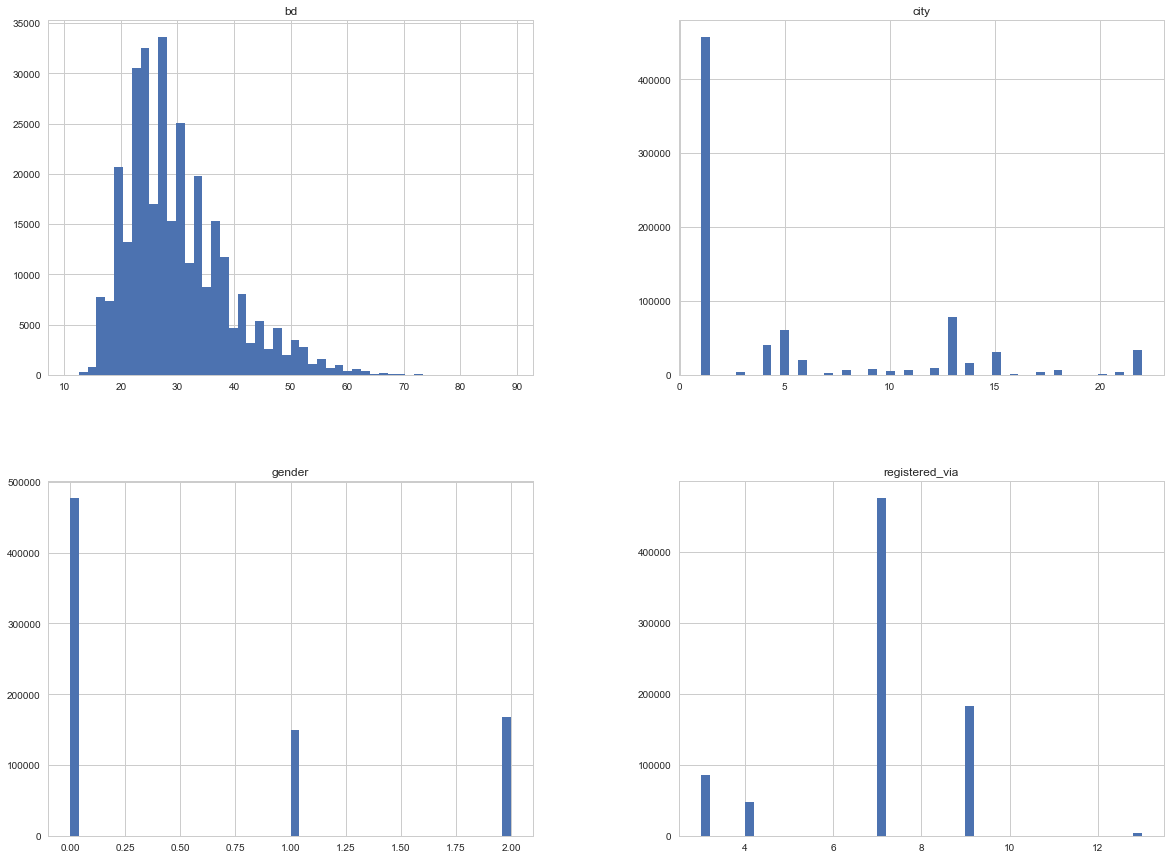

In [17]:
members.hist(bins=50, figsize=(20,15)) 

In [11]:
# One hot encoding for members dataframe
features = ['city','gender','registered_via']

for f in features:
    members_dummy = pd.get_dummies(members[f], prefix = f)
    members = members.drop([f], axis = 1)
    members = pd.concat((members, members_dummy), axis = 1)

In [ ]:
transactions.hist(bins=50, figsize=(20,15)) 
plt.show()

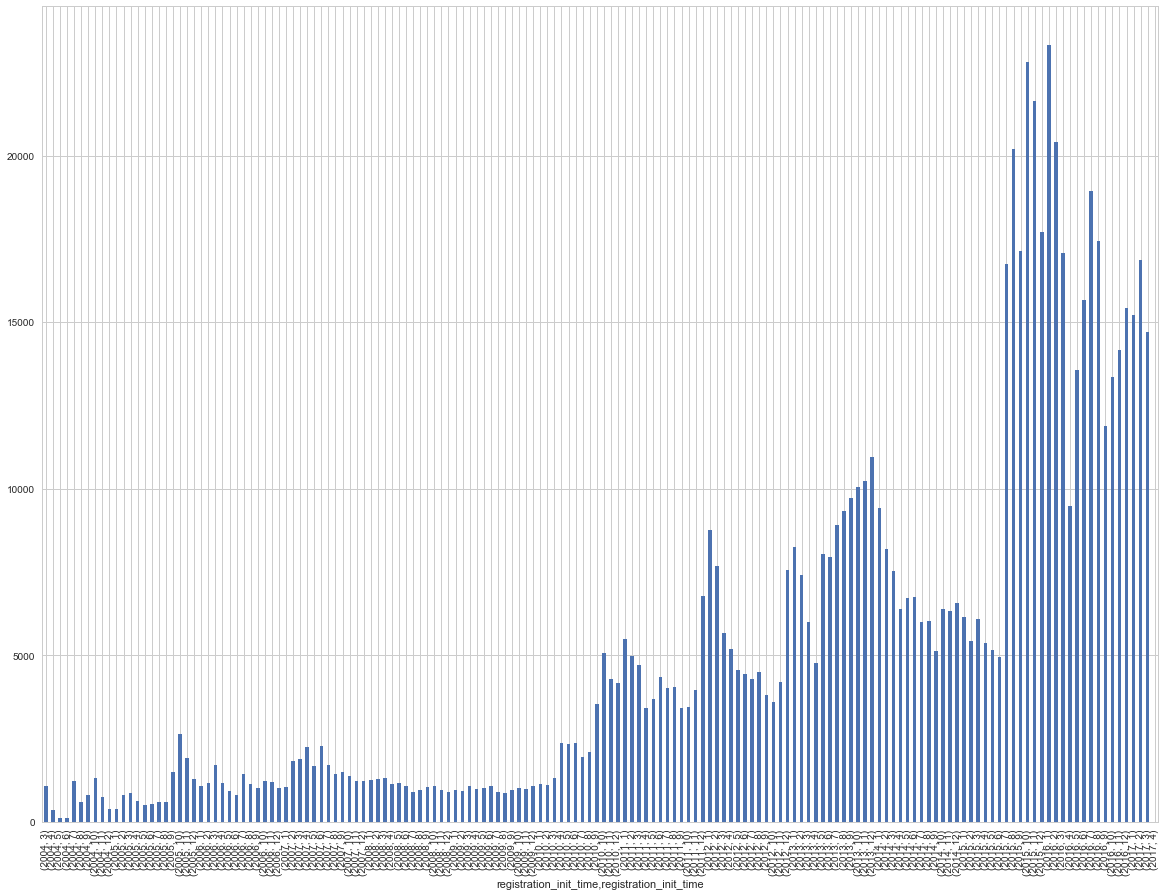

In [12]:
members["registration_init_time"].groupby([members["registration_init_time"].dt.year, members["registration_init_time"].dt.month]).count().plot(kind="bar", figsize=(20,15))

In [ ]:
transactions.columns

In [62]:
# One hot encoding for transactions
features = ['payment_method_id']

for f in features:
    transactions_dummy = pd.get_dummies(transactions[f], prefix = f)
    transactions = transactions.drop([f], axis = 1)
    transactions = pd.concat((transactions, transactions_dummy), axis = 1)

KeyError: 'payment_method_id'

u'Imputed 2688826 empty values to 0.'

# Creating new features

## For the members table

In [19]:
# Total duration of the membership
members["duration_of_membership"] = (members["registration_init_time"]-pd.to_datetime(2017-04-01)).dt.days

In [20]:
# Number of total transactions made
tmpdf = pd.DataFrame()
tmp1=transactions['msno'].value_counts() 
tmpdf["transaction_count"] = tmp1
tmpdf["msno"] = tmpdf.index
members2 = pd.merge(tmpdf, members, on='msno', how='left')
#tmp1=df_comb[df_comb.msno=="f/CqixCvjsoTwQRY8A09SMBMsM0cRcG8BSUe48Bd2Mg="]

In [ ]:
# most common payment method ID across transactions
# most common payment plan days
# What percent of transactions have had auto-renew?
# Does the last transaction have an auto-renew?
# What is the number of days between membership expiration and beginning of April?
# Are only potential users on this list? Or should a group of users be automatically predicted to cancel if the membership expiration date has passed and they have cancelled? 

## For the transactions table

In [21]:
# Size of discount
transactions['discount'] = transactions["plan_list_price"] - transactions["actual_amount_paid"] 
# Whether client got a discount
transactions['is_discount'] = transactions.discount.apply(lambda x: 1 if x > 0 else 0)
# How much did it cost per day
transactions['amt_per_day'] = transactions['actual_amount_paid'] / transactions['payment_plan_days']

# Merging transactions and members dataframes

In [22]:
df_comb = pd.merge(transactions, members2, on='msno', how='left')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11baddf90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x120ab8a90>]], dtype=object)

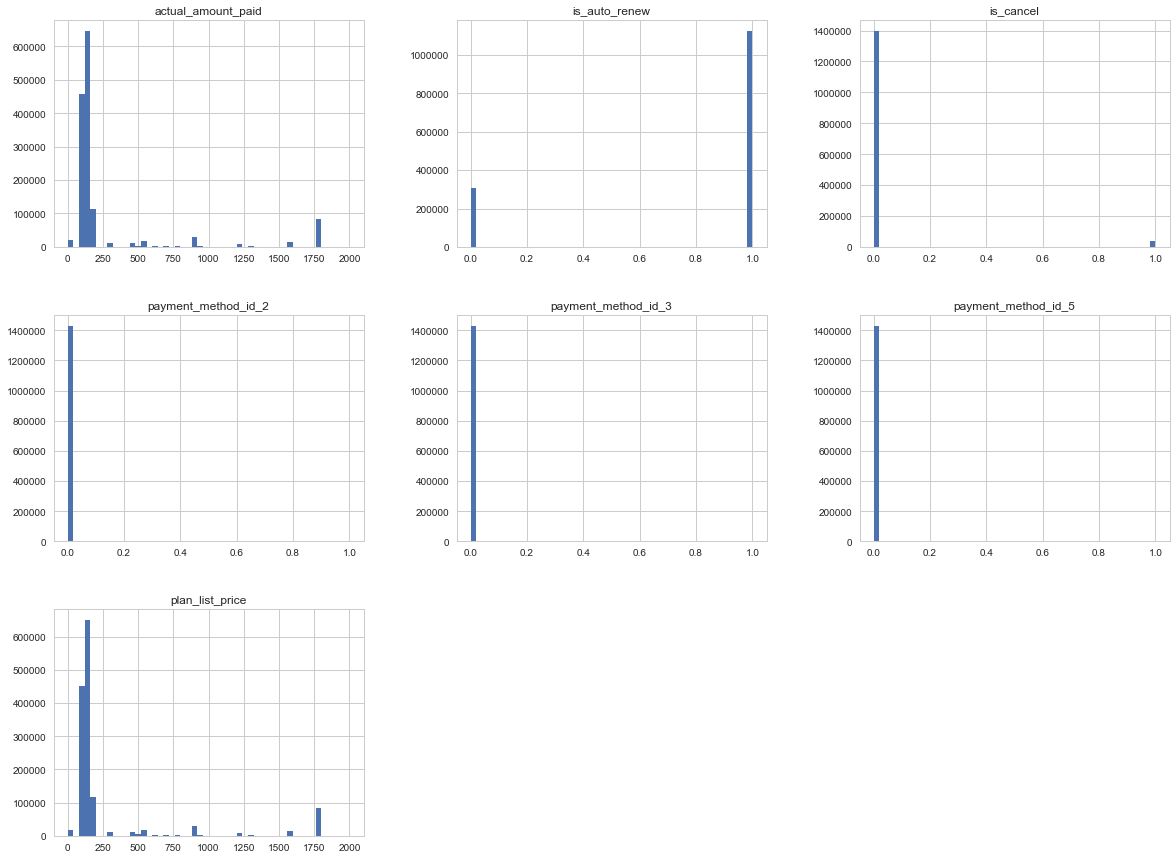

In [26]:
df_comb.iloc[:,2:11].hist(bins=50, figsize=(20,15))

In [38]:
#sml.plot.distribute()
# FIX THIS!

# Merging information

In [23]:
training_info = df_comb[df_comb['msno'].isin(trainset["msno"])]
training_info = pd.merge(training_info, trainset, how='left', on="msno")


numeric_training_info = training_info.drop(["msno", "membership_expire_date", "registration_init_time", "transaction_date"], axis=1)

In [33]:
training_info.to_csv("../../Downloads/Predict_churn/kkboxtrainset.csv")

# Exploring relationship between features

In [ ]:
numeric_training_info.iloc[:,:12].apply(lambda s: numeric_training_info.iloc[:,0:12].corrwith(s))
# WHAT DOES LAMBDA DO?
# How to look at the correlation between dates?

In [ ]:
corr = numeric_training_info.iloc[:,:12].corr()
_ , ax = plt.subplots( figsize =( 12 , 10 ) )
cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
_ = sns.heatmap(corr, cmap = cmap, square=True, cbar_kws={ 'shrink' : .9 }, ax=ax) # , annot = True, annot_kws = {'fontsize' : 12 }

In [ ]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(numeric_training_info.iloc[:,:12][numeric_training_info.iloc[:,:12].columns.difference(["bd"])], hue = "is_churn")

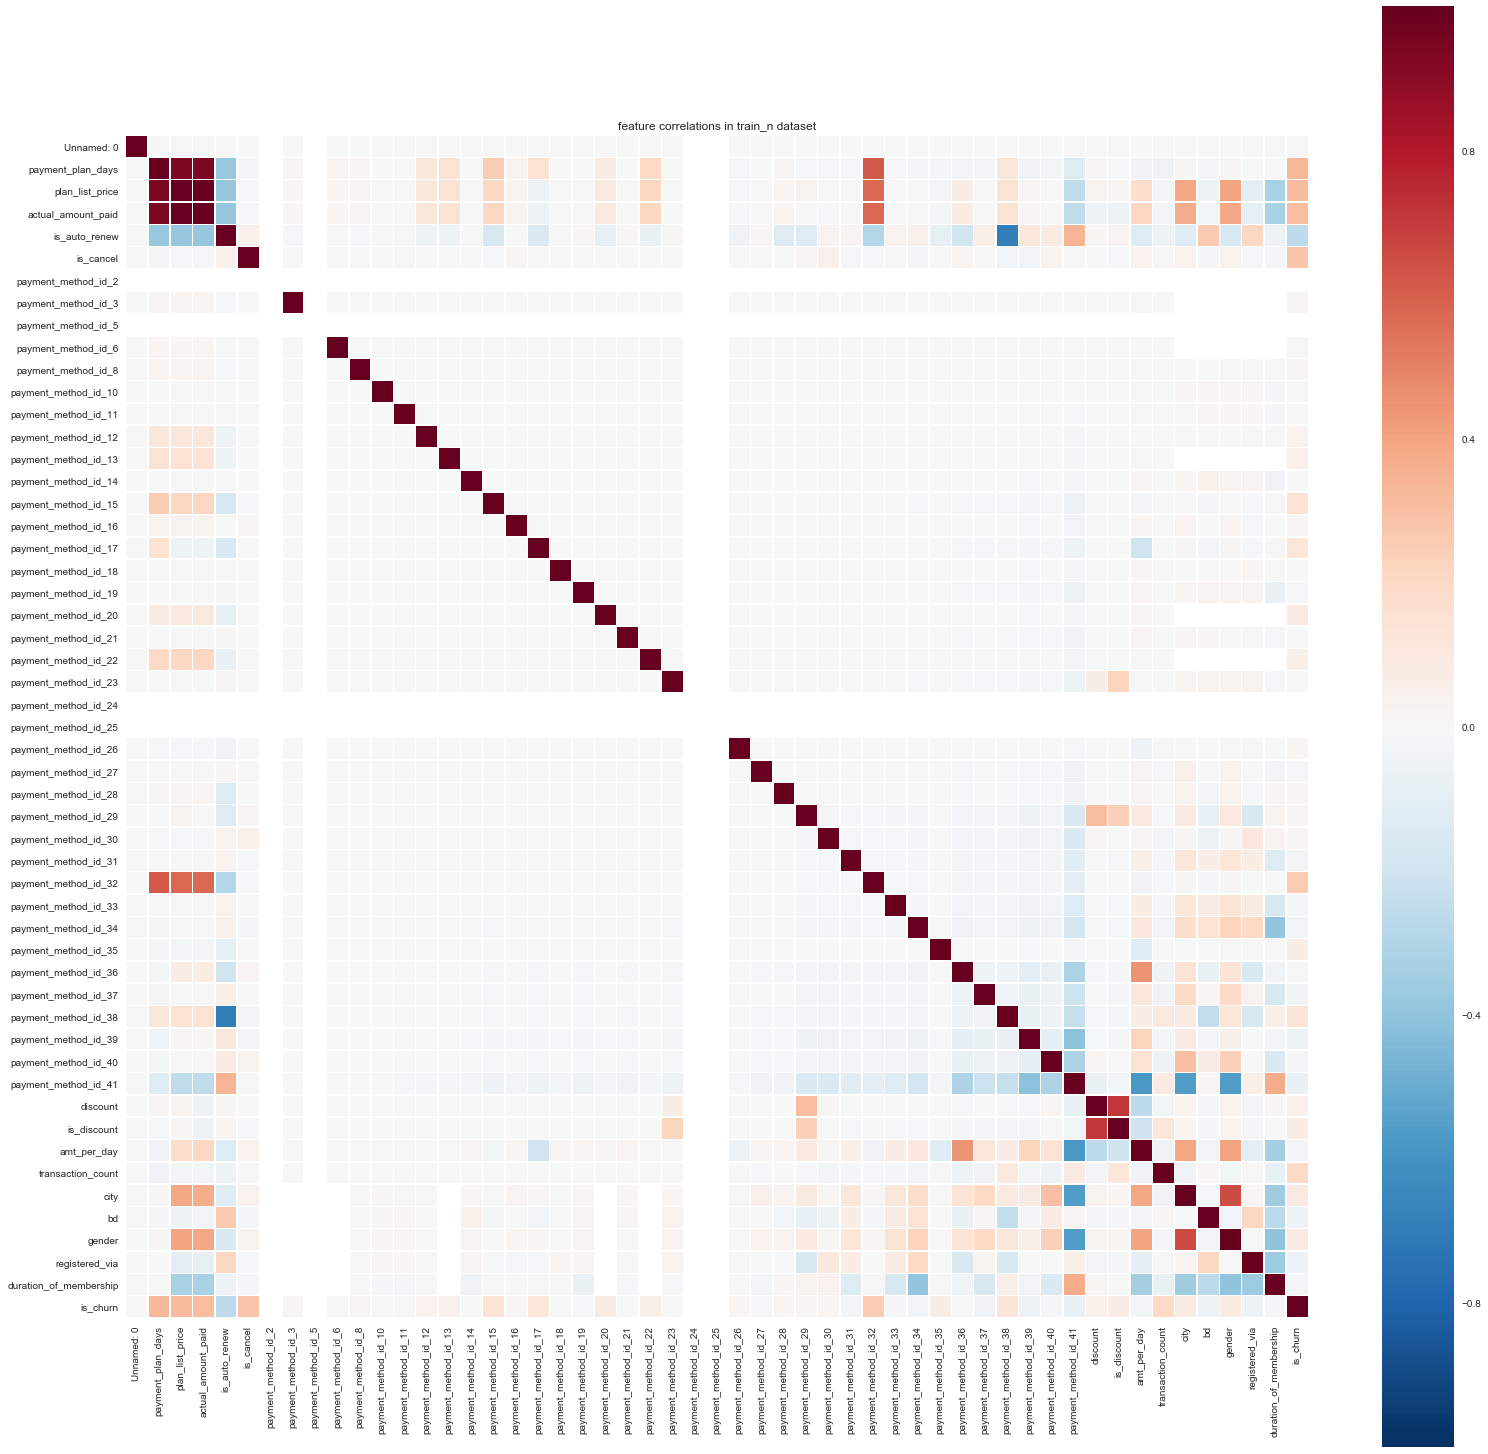

In [36]:
sml.plot.correlate()

In [ ]:
#Registered Via
registered_via_crosstab=pd.crosstab(training_info['registered_via'],training_info['is_churn'])
registered_via_crosstab.plot(kind='bar', stacked=True, grid=True)
registered_via_crosstab["Ratio"] =  registered_via_crosstab[1] / registered_via_crosstab[0]
registered_via_crosstab

In [ ]:
#city
city_crosstab=pd.crosstab(training_info['city'],training_info['is_churn'])
city_crosstab.plot(kind='bar', stacked=True, grid=True)
city_crosstab["Ratio"] =  city_crosstab[1] / city_crosstab[0]
city_crosstab

# Creating training and validation sets

In [45]:
numeric_training_info = training_info.drop(["membership_expire_date", "registration_init_time", "transaction_date"], axis=1)
#training_info2 = training_info.drop(["transaction_date", "membership_expire_date"], axis=1)

#Filling in each column with the most frequent value
numeric_training_info = numeric_training_info.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [46]:
train_set, val_set = train_test_split(numeric_training_info, test_size=0.2, random_state=42)

In [47]:
y_train = np.asarray(train_set["is_churn"])
x_train = np.asarray(train_set.drop(["is_churn","msno"], axis=1))

y_val = np.asarray(val_set["is_churn"])
x_val = np.asarray(val_set.drop(["is_churn", "msno"], axis=1))

In [48]:
x_train = x_train.astype(int)
x_val = x_val.astype(int)
# perhaps should not be integers?

# Trying different classifiers

### Logistic Regression

In [241]:
logreg = LogisticRegression(random_state=0)
#cross_val_score(clf, x_train, y_train, cv=10)
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_val)
print logreg.score(x_val, y_val)
# True positives, True negatives
# False positives, False negatives
print confusion_matrix(y_pred, y_val)
print log_loss(y_val, y_pred)

0.118203895948
[[   807   1560]
 [204678  26839]]
30.4568582123


### SGD Classifier
Since this got worse results than GBC, it was not used 

In [217]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train)
y_pred = sgd_clf.predict(x_val)
print sgd_clf.score(x_val, y_val)
# True positives, True negatives
# False positives, False negatives
print confusion_matrix(y_pred, y_val)
print log_loss(y_val, y_pred)

0.864073643345
[[198166  24472]
 [  7319   3927]]
4.69475506073


### Decision Tree classifier

In [223]:
clf = DecisionTreeClassifier(random_state=0)
#cross_val_score(clf, x_train, y_train, cv=10)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_val)
print clf.score(x_val, y_val)
# True positives, True negatives
# False positives, False negatives
print confusion_matrix(y_pred, y_val)
print log_loss(y_val, y_pred)

# What does the cross validation score do exactly?

0.948709616733
[[196870   3381]
 [  8615  25018]]
1.77153653164


### Gradient boosting classifier

Kaggle - 2.07955

In [315]:
model = GradientBoostingClassifier()
model.fit(x_train,y_train)
y_pred = model.predict(x_val)
print model.score(x_val, y_val) 
#Implement the real log formula here
# True positives, True negatives
# False positives, False negatives
print confusion_matrix(y_pred, y_val)
print log_loss(y_val, y_pred)

0.950988524226
[[198725   4703]
 [  6760  23696]]
1.69281951349


[ 0.1302184   0.83439558  1.        ]
[ 1.          0.77804045  0.        ]
[0 1]


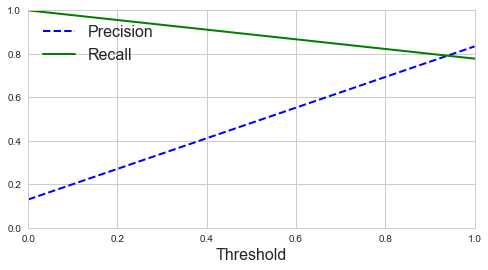

In [323]:
from sklearn.metrics import precision_recall_curve
# What to do with this? How to set the right treshold?


precisions, recalls, thresholds = precision_recall_curve(y_pred, y_val)
print precisions
print recalls
print thresholds

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([0, 1])
plt.show()

### XGBoost classifier
Kaggle - 1.61071

In [52]:
model = XGBClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_val)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_val, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print model.score(x_val, y_val) 
#Implement the real log formula here
# True positives, True negatives
# False positives, False negatives
print confusion_matrix(y_pred, y_val)
print log_loss(y_val, y_pred)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

Accuracy: 96.61%
0.96608777075
[[201497   5340]
 [  2338  17233]]
1.17129516015


### Random Forest Classifier
Kaggle - 2.15452

In [242]:
clf = RandomForestClassifier(random_state=0)
#cross_val_score(clf, x_train, y_train, cv=10)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_val)
print clf.score(x_val, y_val)
# True positives, True negatives
# False positives, False negatives
print confusion_matrix(y_pred, y_val)
print log_loss(y_val, y_pred)

# What does the cross validation score do exactly?

0.95307930427
[[198030   3519]
 [  7455  24880]]
1.62060890508


### Neural network

In [245]:
# baseline model
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(60, input_dim=77, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [255]:
model=create_baseline()
model.fit(x_train, y_train, batch_size=5, nb_epoch=1,
          verbose=1, validation_data=(x_val, y_val))

Train on 935534 samples, validate on 233884 samples
Epoch 1/1
479290/935534 [==============>...............] - ETA: 203s - loss: 1.9770 - acc: 0.8773

KeyboardInterrupt: 

In [258]:
y_pred = model.predict(x_val)
score = model.evaluate(x_val, y_val, verbose=0)
print "Loss and accuracy"
print score

y_pred = (y_pred>0.5).astype(int)
#print model.score(x_val, y_val)
# True positives, True negatives
# False positives, False negatives
print confusion_matrix(y_pred, y_val)
print log_loss(y_val, y_pred)

Loss and accuracy
[1.9571146080952209, 0.87857655931694667]
[[205485  28399]
 [     0      0]]
4.19381706675


In [ ]:
import cPickle
# save the classifier
with open('my_dumped_classifier.pkl', 'wb') as fid:
    cPickle.dump(gnb, fid)    

# load it again
with open('my_dumped_classifier.pkl', 'rb') as fid:
    gnb_loaded = cPickle.load(fid)

# Combining training results in a dataframe

In [162]:
#Generating only one score per msno id
submission_transactions= pd.DataFrame({
        "msno": val_set["msno"],
        "is_churn": y_pred
    })


grouper = submission_transactions.groupby(["msno"])
churn_likelihood = grouper.sum()/grouper.count()

submission= pd.DataFrame({
        #"msno": churn_likelihood.index,
        "is_churn": churn_likelihood["is_churn"]
    })

In [163]:
float(sum(submission["is_churn"]))/len(submission)

0.1144181199704366

In [164]:
float(sum(trainset["is_churn"]))/len(trainset)

0.08994191315811156

In [211]:
from IPython.display import Image
from sklearn import tree

dot_data = tree.export_graphviz(model, out_file='tree.dot', 
                         filled=True, rounded=True,  
                         special_characters=True)  

AttributeError: 'GradientBoostingClassifier' object has no attribute 'tree_'

# Creating test set 

In [26]:
#test_info = pd.merge(df_comb, samplesubmission, how='inner', on="msno")
#test_info  = pd.concat([samplesubmission, df_comb], axis=1, join_axes=["msno"], how="")
test_info = df_comb[df_comb['msno'].isin(samplesubmission["msno"])]
#numeric_training_info = training_info.drop(["msno", "membership_expire_date", "registration_init_time", "transaction_date"], axis=1)

In [27]:
#print len(set(df_comb["msno"]))
#print df_comb["msno"].value_counts()

# would expect 372 rows. 
test_info = df_comb[df_comb['msno'].isin(samplesubmission["msno"])]

In [28]:
numeric_test_info = test_info.drop(["membership_expire_date", "registration_init_time", "transaction_date"], axis=1)

#Filling in each column with the most frequent value
numeric_test_info = numeric_test_info.apply(lambda x:x.fillna(x.value_counts().index[0]))

x_test = np.asarray(numeric_test_info.drop(["msno"], axis=1)).astype(int)

In [34]:
test_info.to_csv("../../Downloads/Predict_churn/kkboxtestset.csv")

# Making predictions on test set

In [53]:
test_pred = model.predict(x_test)

In [54]:
float(sum(test_pred))/len(test_pred)

0.02856411900329195

In [55]:
submission_transactions = pd.DataFrame({
        "msno": test_info["msno"],
        "is_churn": test_pred
    })

grouper = submission_transactions.groupby(["msno"])
total_score = grouper.sum()
churn_likelihood = total_score/grouper.count()

submission= pd.DataFrame({
        "msno": churn_likelihood.index,
        "is_churn": churn_likelihood["is_churn"]
    })

#submission['is_churn'] = submission.is_churn.apply(lambda x: int(1) if x > 0.5 else int(0))

In [56]:
submission.head()

,is_churn,msno
msno,,
+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0.0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=
+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,0.0,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=
++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,0.0,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=
++0/NopttBsaAn6qHZA2AWWrDg7Me7UOMs1vsyo4tSI=,0.0,++0/NopttBsaAn6qHZA2AWWrDg7Me7UOMs1vsyo4tSI=
++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=,0.0,++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=


In [57]:
#submission["is_churn_y"] = submission.is_churn.astype(float)
#del submission_final['is_churn_x']
#submission.columns = ["is_churn","msno"]

submission = submission[["msno", "is_churn"]]
submission.head()

,msno,is_churn
msno,,
+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0.0
+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,0.0
++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,0.0
++0/NopttBsaAn6qHZA2AWWrDg7Me7UOMs1vsyo4tSI=,++0/NopttBsaAn6qHZA2AWWrDg7Me7UOMs1vsyo4tSI=,0.0
++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=,++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=,0.0


In [58]:
# Adding the one missing msno
data = {'msno': ['VJx7ZXB+BP/true7UpJTYyAsv7ItjWWaRrtY/Zg0+VE='], "is_churn" : [0.0]}
tmpdf = pd.DataFrame(data)
tmpdf = tmpdf.set_index("msno")
tmpdf
submission2 = submission.append(tmpdf)

,is_churn
msno,
VJx7ZXB+BP/true7UpJTYyAsv7ItjWWaRrtY/Zg0+VE=,0.0


In [59]:
submission2 = submission2["is_churn"]
len(submission2)

907471

In [60]:
submission2.to_csv('../../Downloads/kkbox.csv', index=True, header=True)